<a href="https://colab.research.google.com/github/gtbook/robotics/blob/main/S72_drone_actions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install -q -U gtbook

Note: you may need to restart the kernel to use updated packages.


In [2]:
import math
import numpy as np
import pandas as pd

import plotly.express as px
try:
    import google.colab
except:
    import plotly.io as pio
    pio.renderers.default = "png"

import gtsam
from gtbook.drone import axes

# Multi-rotor Aircraft

> An amazing way to fly in 3D.

**This Section is still in draft mode and was released for adventurous spirits (and TAs) only.**

In [3]:
from gtbook.display import randomImages
from IPython.display import display
display(randomImages(7, 2, "steampunk", 1))

The kinematics of quadrotors and multicopters are those of simple rigid 3D bodies. Many different coordinate frame conventions are used in the literature. I introduce one good choice below, and convert equations from the literature to this convention where needed.

The kinematics equations are most useful for navigation and control when expressed in the navigation frame $\mathcal{N}$, which for MAV applications is almost universally assumed to be non-rotating and aligned with gravity, but can otherwise be defined arbitrarily, e.g., **East-North-Up (ENU)**. The origin of the navigation frame is often chosen as the take-off point, but does not have to be.

We also define a body frame $\mathcal{B}$ as having its origin at the center of mass of the vehicle. Following convention in aerospace applications, we fix the x-axis as pointing to the front of the vehicle (not always the direction of travel), the y-axis as pointing to the left, and the z-axis pointing up, the so-called **FLU convention**. 

We then define, respectively,

• the vehicle's position $r^{n}\doteq[x,y,z]^{T}$,

• its linear velocity $v^n=\dot{r^{n}}\doteq[u,v,w]^{T}$,

• the attitude $R^n_b\doteq[i^b,j^b,k^b]\in SO(3)$, a $3\times 3$ rotation matrix from $\mathcal{B}$ to $\mathcal{N}$,

• the body angular velocity $\omega^b\doteq[p,q,r]^{T}$.

Above the superscript $n$ and $b$ denote quantities expressed in the *navigation* and *body* frame, respectively. 

## Drone Dynamics

Let us take the [Skydio 2+](https://www.skydio.com/skydio-2-plus) as a prototypical and relevant example. Its mass, with battery, is $800g$, but let's just say $1kg$ to make the calculations easier. Its dimensions are $229mm \times 274mm$, but let's assume the motors are at $(+/- 0.10m, +/- 0.10m)$, which is not too far off.

## Hover
To hover, assuming $g=10m/s^2$, the four rotors have to provide a thrust of 10N upwards to compensate for gravity, i.e., 2.5N per motor. Of course, we need to be able to accelerate upwards, so let's assume each motor can provide up to double that, i.e., 0 to 5N. So, while the drone is level, here are some sample accelerations we can deliver:

- $f_i=0N$ for $i\in{1..4}$: downwards acceleration at $-10\frac{m}{s^2}$.
- $f_i=2.5N$ for $i\in{1..4}$: stable hover $0\frac{m}{s^2}$.
- $f_i=5N$ for $i\in{1..4}$: upwards acceleration at $10\frac{m}{s^2}$.

In general, the force $F^b_z$ aligned with the body Z-axis will be  

$$
F^b_z = \sum_{i=1}^4 f_i
$$

## Forward Flight

Of course, when we *tilt* the quadrotor forwards, we will direct some of that thrust towards generating horizontal acceleration. To get a handle on this, we need to calculate the thrust in the *navigation* frame, but this is just a matter of multiplying with the rotation matrix $R^n_b$:

$$
F^n = R^n_b \begin{bmatrix}0 \\ 0 \\ F^b_z\end{bmatrix} = \hat{z}^n_b F^b_z
$$

where $\hat{z}^n_b$ is the third column of $R^n_b$, i.e., this is simply the Z-axis $\hat{z}$ of the body frame, expressed in the navigation frame. *In other words, the thrust in the navigation frame is always aligned with the body's Z-axis, and hence by rotating the quadrotor appropriately we can achieve any thrust direction we desire*.

Let us assume that the FLU body frame is currently oriented along the Y-axis of the ENU navigation frame, i.e., we are flying NORTH, then if we tilt forward with an angle of $\theta$ with respect to vertical, we obtain 

$$
F^n = \begin{bmatrix}0 \\ \sin \theta \\ \cos \theta\end{bmatrix} F^b_z
$$

and hence if we want to maintain level flight, we need to keep compensating for gravity by maintaining

$$
\cos \theta F^b_z = 10N.
$$

That in turn means that the forward trust (along the navigation Y-axis) will be

$$
F^n_y = \sin \theta F^b_z = \sin \theta \frac{10N}{\cos \theta} = \tan \theta \cdot 10N 
$$


## Maximum Tilt and Thrust

We are also constrained, however, by the maximum thrust $F^b_z$ we can deliver, which is 20N. Hence,

$$
F^b_z = \frac{10N}{\cos \theta} \leq 20N \rightarrow \cos \theta \geq 0.5 \rightarrow -60^\circ \leq \theta \leq 60^\circ,
$$

the maximum tilt angle is 60 degrees. At that maximum tilt angle, we have

$$
F^n_y = \tan \theta_{\max} \cdot 10N \approx 17N 
$$

So, we are limited to $17N$ of forward thrust, and this when tilting very aggressively at 60 degrees. If we tilt more, we can improve thrust even more (up to 20N) but the drone will start falling out of the sky. 

## Drag and Maximum Velocity

Importantly, constant forward thrust does *not* mean that the drone will continue accelerating, because of *drag*. In fact, from the spec-sheet of the Skydio-2 we see that the top speed (in autonomous mode) is 36Mph, which is about $16m/s$, and the theoretical top speed is probably more like $20m/s$. Since drag increases *quadratically* with velocity, we can calculate the corresponding drag coefficient as the drag force has to exactly balance the maximum forward thrust at the top speed:

$$
17N = k_d v_{top}^2 = k_d 20^2 m^2/s^2 \rightarrow k_d = 0.0425
$$

Now that we have the drag coefficient $k_d$, we can calculate a simple mapping from tilt angle $\theta$ to forward velocity. Indeed, given tilt $\theta$, can calculate the forward thrust $F^n_y$ in the navigation frame, and the velocity can be obtained by equating that to the drag force $k^d v^2$:

$$
F^n_y = \tan \theta \cdot 10N = k_d v^2 \rightarrow v = \sqrt{\frac{\tan \theta \cdot 10}{k_d}} = \sqrt{\frac{10}{k_d}} \sqrt{\tan \theta} \approx 15 \sqrt{\tan \theta}
$$

In [4]:
vmap = {}
for theta in [0,1,5,10,15,20,30,40,50]:
  vmap[theta] = 15 * math.sqrt(math.tan(math.radians(theta)))
  print(f"v({theta}) ~ {round(vmap[theta])} m/s")

v(0) ~ 0 m/s
v(1) ~ 2 m/s
v(5) ~ 4 m/s
v(10) ~ 6 m/s
v(15) ~ 8 m/s
v(20) ~ 9 m/s
v(30) ~ 11 m/s
v(40) ~ 14 m/s
v(50) ~ 16 m/s


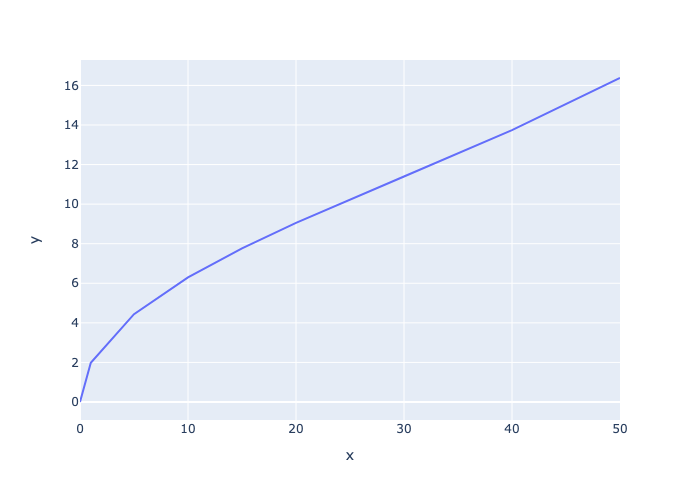

In [5]:
px.line(x=list(vmap.keys()), y= list(vmap.values()))

## Full Rigid-Body Kinematics

Below I develop all attitude kinematics and dynamics directly on $SO(3)$, following Murray et al. (1994).
In particular, the vehicle's kinematics are given by 

$$
\begin{align}
\dot{r}^{n}	&= v^n \\
\dot{R}^n_b	&= R^n_b\hat{\omega}^b
\end{align}
$$

where the $3\times 3$ skew-symmetric matrix $\hat{\omega}^b\doteq (R^n_b)^{T}\dot{R}^n_b$ is obtained from the 3-vector $\omega^b$ as follows:

$$
\hat{\omega}^b\doteq\begin{bmatrix}
 & -\omega^b_{z} & \omega^b_{y}\\
\omega^b_{z} &  & -\omega^b_{x}\\
-\omega^b_{y} & \omega^b_{x}
\end{bmatrix}.
$$

Note $\hat{\omega}^b\in so(3)$, the Lie algebra associated with the 3D rotation group $SO(3)$. 
Also, the kinematics can also expressed using the spatial angular velocity $\omega^n\doteq R^n_b\omega^b$, i.e.,

$$
\dot{R}^n_b	= \hat{\omega}^n R^n_b
$$

However, it is much easier to visualize and calculate the angular velocity in the body frame.

## Simulation aka Forward Integrating

If time histories $v^n(t)$ and $\omega^b(t)$ for the linear and angular velocities are available, the vehicle's position $r^{n}(t)$ and attitude $R^n_b(t)$ can be integrated forward using the following two equations:

$$
\begin{align}
r^n_{k+1} &= r^n_{k} + d^k_{k+1}[v^n(t), \Delta t]\\
R^n_{b,k+1} &= R^n_{b,k} R^k_{k+1}[\omega^b(t), \Delta t]
\end{align}
$$

where $\Delta t$ is the sample time and 

- $d^k_{k+1}[v^n(t), \Delta t]$ is the relative displacement obtained by exactly integrating the velocity $v^n(t)$ over the interval $(t_k,t_{k+1}]$, and
- $R^k_{k+1}[\omega^b(t), \Delta t]$ is the relative rotation obtained by exactly integrating the angular velocity $\omega^b(t)$ over that same interval.

### Integrating Position

The above is exact, but when implementing this in code we need to use a numerical integration scheme. For position, the simplest integration scheme is the **forward Euler method**

$$
d^k_{k+1}[v^n(t), \Delta t] \approx v^n(t_k) \Delta t
$$

which approximates velocity $v^n(t)$ over the interval $(t_k,t_{k+1}]$ as constant with value $v^n(t_k)$. There is also the **backward Euler method**, which uses $v^n(t_{k+1})$, and the **trapezoidal method**, which uses the average $0.5v^n(t_k)+0.5v^n(t_{k+1})$. More sophisticated integration schemes are possible, allowing for larger sample times $\Delta t$, but they require more function evaluations of the velocity.

### Integrating Attitude

For the attitude part, it turns out that the Euler method can be implemented *in closed form* using **Rodrigues' rotation formula**:

$$
R^k_{k+1}[\omega^b(t), \Delta t] \approx I + \sin\theta K + (1-\cos\theta) K^2
$$

where $\theta=\|\omega^b_k\| \Delta t$ is the amount of rotation over the $\Delta t$ interval, and the $3\times 3$ matrix $K=\hat{\omega}^b_k/\|\omega^b_k\|$ is the screw symmetric matrix $\hat{\omega}^b_k$ normalized by $\|\omega^b_k\|$. The approximation sign above is because this is *still* an Euler step, only exact if the time-varying angular velocity $\omega^b(t)$ is actually constant over the interval.
This formula is also sometimes written in terms of an exponentiation,

$$
\exp \{ \hat{\omega}^b_k \Delta t \} = I + \sin\theta K + (1-\cos\theta) K^2
$$
because Rodrigues' formula is also the expression of the *exponential map* in $SO(3)$, a concept that generalizes to other Lie groups and which we will encounter again later in this chapter.

The last term in Rodrigues' formula is typically small for small sample times $\Delta t$ because (a) $(1-\cos\theta)$ is small for small $\theta$, and (b) the matrix $K^2$ contains squares of numbers smaller than 1. Hence, an often used first-order approximation for Euler's method in rotation spaces is

$$
R^k_{k+1}[\omega^b(t), \Delta t] \approx I + \sin\theta K \approx I + \hat{\omega}^b_k \Delta t =
\begin{bmatrix}
1 & -\omega^b_{z}\Delta t  & \omega^b_{y}\Delta t \\
\omega^b_{z}\Delta t  & 1 & -\omega^b_{x}\Delta t \\
-\omega^b_{y}\Delta t  & \omega^b_{x}\Delta t  & 1
\end{bmatrix}
$$
where we also used the small angle approximation $\sin \theta \approx \theta$.
Note that strictly speaking this approximation (unlike Rodrigues` formula) departs the rotation manifold and we need to periodically re-normalize to ensure that $R^n_b\in SO(3)$.


## An Example in Code

We demonstrate the above by forward integrating a quadrotor's position and orientation starting from a "forward flight" configuration at the origin, i.e., pitched forward by 10 degrees. We first specify the attitude using `Rot3.Pitch`:

In [6]:
nRb0 = gtsam.Rot3.Pitch(math.radians(10))
print(np.round(nRb0.matrix(),2))

[[ 0.98  0.    0.17]
 [ 0.    1.    0.  ]
 [-0.17  0.    0.98]]


Note that the forward X-axis (first column) is pointed slightly down, the Y-axis is level, and the Z-axis is pointed up but slightly forward. We have calculated before that the velocity at this angle is $6~m/s$, and let us also assume that the 4 rotors conspire to create a small angular velocity around the vertical body axis:

In [7]:
vb = gtsam.Point3(6,0,0)
wb = gtsam.Point3(0,0,math.radians(10)) # 10 degrees per second

We can now integrate these, taking care to convert the body velocity to the navigation frame at each time step:

In [8]:
delta_t = 1 # in seconds
K = 10 # number of intervals to integrate

# allocate storage for time series and initialize for k=0
rn = np.zeros((3, K+1), float)
rn[:,0] = gtsam.Point3(0,0,0)
nRb = np.zeros((3, 3, K+1), float)
nRb[:,:,0] = nRb0.matrix()

# integrate forward
for k in range(K):
    vn = nRb[:,:,k] @ vb
    vn[2] = 0 # we assume gravity is compensated for
    rn[:,k+1] = rn[:,k] + vn * delta_t
    delta_R = gtsam.Rot3.Expmap(wb * delta_t)
    nRb[:,:,k+1] = nRb[:,:,k] @ delta_R.matrix()

The plotting code is almost as verbose, and this is using the `gtbook.drone.axes` method, which hides more magic to create the axes:

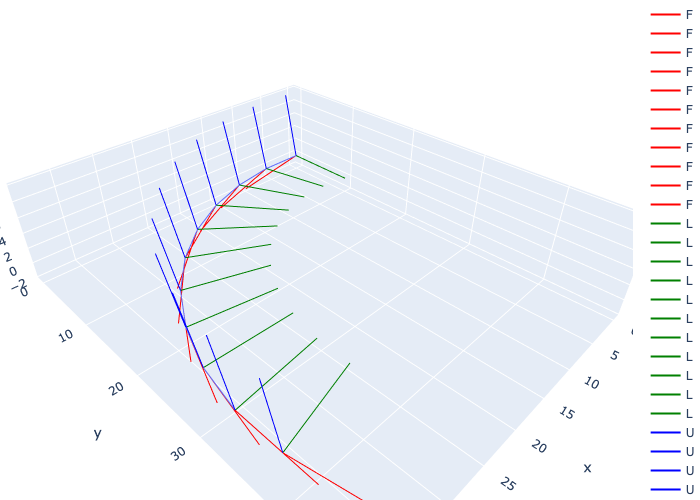

In [9]:
fig = px.line_3d(x=rn[0], y=rn[1], z=rn[2])
scale, labels = 10, ["F", "L", "U"]
for k in range(K+1):
    nTb = gtsam.Pose3(gtsam.Rot3(nRb[:,:,k]), rn[:,k]);
    fig.add_traces(axes(nTb, scale, labels))
fig.update_layout(margin=dict(l=0, r=0, t=0, b=0))
fig.update_layout(scene_aspectmode='data')
fig.show()

You can see that the drone takes off in the positive X-direction, which is East in the ENU convention, and then gradually turns towards the North.

**Exercises**

- Change the initial forward orientation to be the *northern* direction.
- Change the direction of the turn to the other side.
- Change the code to use different values for $\Delta t$ and observe the results.

## Full Rigid-Body Dynamics*

> Not hard to write down, but harder to understand.

Ultimately we need to move a quadrotor to provide forces by the four rotors, which will produce a force and a moment on the quadrotor body. These in turn will generate linear and angular accelerations, through the quadrotor **dynamics**.

To start, everyone knows the famous Newton's law:

$$
F^n = m \dot{v}^n
$$

where the **mass** m is a scalar *resisting* motion: the higher the mass, the higher the force needed to produce an acceleration in any dimension. Note that we could consider $m$ to be a diagonal matrix with the mass on the diagonal: acceleration is resisted the same way in all three axes, in whatever coordinate frame we choose.

The same is (approximately) true for rotational motion

$$
\tau^b \approx I \dot{\omega}^b
$$

where the approximation is good for small angular velocities $\omega^b$. 
The inertial matrix $I$ is typically a diagonal matrix with "small-small-big" diagonal elements in the FLU body coordinate frame, as the motor masses are further away from the Z-axis than from the X and Y axes, and hence resist acceleration around the Z-axis more.

One last step is still missing, which is how to translate from forces at the rotors to a force and moment on the *body*. In the body coordinate frame, the force equation is easy:

$$
F^b_z = \sum_i f_i.
$$

Above the forces $f_i$ at the rotors are all oriented along the body Z-coordinate axis (up!) and hence when we sum them we get a single force component $F^b_z$ along the body Z-axis.

The torque $\tau^b$ in the body frame is a bit more involved, and is a function of the force vector $f$ as well as the vector $\tau$, specifying the (small) torques generated around each rotor axis. The exact formula depends on the geometry of the rotors. For example, for a 4-motor “X” configuration with motor 1 forward left and numbered clockwise, we obtain

$$
\tau^b = \begin{bmatrix}
(f_{1}-f_{2}-f_{3}+f_{4})l\\
(f_{1}+f_{2}-f_{3}-f_{4})l\\
\sum_i\tau_{i}
\end{bmatrix}
$$

where $l$ is the distance from the rotors to the center of mass.
From this equation you can see that a quadrotor is like a differential drive robot but with *two* differential axes. Controlling it is easy in principle: *tilt, then move*. A part of $F^b_z$ will be used to keep the quadrotor flying, the other part will be used to overcome drag.

## Gyroscopic effects*

> Dotting the I's.

If a quadrotor undergoes large angular velocities, we cannot ignore gyroscopic effects and we have to modify the moment dynamics equation above to

$$
\tau = I \dot{\omega}^b - \omega^b \times I \omega^b,
$$

where $\times$ is the cross-product. The second term is a set of quadratic components in the angular velocity $\omega^b$ and that is why for small angular velocities they can be ignored. In fact, in many cases the orientation of a quadrotor is *actively controlled* to stay constant during hovering or in fast forward flight, and it is only in complicated maneuvers that large angular velocities occur.